# Data interpolation and visualisation

In the previous notebook, we analyzed numerical data related to the occurrence of snow on Christmas. However, it is much better to visualize geographical data on a real map. For this we need to do:
- create a function that will generate a dataframe with all the necessary data, especially geographic coordinates
- data on the occurrence of snow throughout Poland must be interpolated
- putting interpolated data on a map with marked areas with a chance of snow
- compare data for each decade by creating separate charts

## Function that generates a dataframe with data for a specific time period

For further analysis, we will create a function that:
- generates a dataframe with data like: snow occurrence ratio, station longitude and latitude
- takes a specific time period as an argument and a new dataframe is created within that time frame 

In [1]:
import pandas as pd

df = pd.read_csv('data/snow_data_all_filtered.csv')

In [6]:
def snow_data_range(dataframe, period):
    
    # Selecting records from a dataframe for a given time period (argument as a tuple)
    df = dataframe.loc[(dataframe['year'] >= period[0]) & (dataframe['year'] <= period[1])]
   
    # Creating the Series with station names
    station_name = df.groupby('station_id').first()[['station_name','lat','lon']]

    # Creating the Series with number of total years of measurements
    total_years = df.groupby('station_id')['station_name'].count()

    # Creating the Series with all snowy years counted (with snow cover of at least 2 cm)
    snowy_years = df.groupby('station_id').apply(lambda x: x[x['snow'] > 1 ]['year'].count())

    # Creating the Series with calculated snow occurrence ratio (simply dividing number of snowy years by number of total years for each station)
    snow_occurr = (snowy_years / total_years)
 
    # Creating the Series with an average snow cover
    snow_mean =  df.groupby('station_id')['snow'].agg('mean')
    
    # Merging all Series into one final dataframe and adding latitude/longitude columns
    df = pd.concat({"station_name":station_name['station_name'],"total_years":total_years,"snowy_years":snowy_years, \
                  "snow_occurr":snow_occurr,"snow_mean":snow_mean, "lat":station_name['lat'], "lon":station_name['lon']}, axis=1)
    
    # Returning the final dataframe with data only for stations that recorded measurements for almost the entire period defined as a function argument
    return df.loc[df['total_years'] >= (period[1] - period[0])]

In [8]:
# Quick test of the function for data from 1970s

snow_data_range(df,(1970,1979))

,station_name,total_years,snowy_years,snow_occurr,snow_mean,lat,lon
station_id,,,,,,,
249180010,PSZCZYNA,10,2,0.2,1.2,50.000000,18.916667
249189996,JASTRZĘBIE-ZDRÓJ,10,3,0.3,2.0,49.950000,18.566667
249190130,MIĘDZYBRODZIE BIALSKIE,10,4,0.4,4.0,49.800000,19.200000
249190190,MAKÓW PODHALAŃSKI,10,4,0.4,3.4,49.733333,19.683333
249190350,ZAWOJA,10,6,0.6,10.4,49.616667,19.516667
...,...,...,...,...,...,...,...
254199998,TOLKMICKO,10,3,0.3,3.2,54.316667,19.533333
254200080,LIDZBARK WARMIŃSKI,10,3,0.3,2.6,54.133333,20.600000
254219999,GIŻYCKO,10,4,0.4,3.3,54.033333,21.800000


## Data interpolation

The dataset contains data only for a certain number of weather stations located in different parts of Poland. To create a map with snow occurrence areas, we must first interpolate the data on a grid that covers the entire country. We will use a PyKrige library and Ordinary Kriging algorithm for this purpose. 

In [10]:
# Importing pykrige library

from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt

import numpy as np

Let's see how Ordinary Kriging works with an example of the data from 1960s.

In [11]:
# Creating a datframe with data from 1960s using a function snow_data_range()

snow = snow_data_range(df, (1960,1969))

# Converting longitude, latitude, and snow occurrence ratio into numpy arrays 

lons = np.array(snow['lon'])
lats = np.array(snow['lat'])
data = np.array(snow['snow_occurr'])

# Creating a grid space for data interpolation

grid_space = 0.05
grid_lon = np.arange(np.array([13]), np.array([25]), grid_space) 
grid_lat = np.arange(np.array([49]), np.array([55]), grid_space)

# Executing the ordinary kriging algorithm

OK = OrdinaryKriging(lons, lats, data, variogram_model='gaussian', verbose=True, enable_plotting=False)
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)

xintrp, yintrp = np.meshgrid(grid_lon, grid_lat)

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.0696966155306747
Full Sill: 0.08278634417316533
Range: 8.581058943098345
Nugget: 0.013089728642490625 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [16]:
# Checking newly created interpolated data

z1 


masked_array(
  data=[[0.8141002694133146, 0.8135925022665161, 0.813052128039258, ...,
         0.9650250259893292, 0.9641990692383327, 0.9633547337781695],
        [0.8109930948328264, 0.8104617716342122, 0.8098975502390939, ...,
         0.9607817729441067, 0.9600542503152859, 0.9593074285218807],
        [0.807822090598474, 0.8072677030213302, 0.8066801568066708, ...,
         0.9565455976178108, 0.9559162186518453, 0.9552666219874152],
        ...,
        [0.3791535530716364, 0.37815616711789435, 0.37722415359695, ...,
         0.8643722308183206, 0.8654842612780829, 0.8665433410796619],
        [0.37875099288030356, 0.37774296195570656, 0.37680048167817864,
         ..., 0.8648717001675443, 0.865953254077149, 0.8669821016643445],
        [0.3784513699438568, 0.3774324977601894, 0.37647932089648467,
         ..., 0.8653287261695684, 0.8663803620435095, 0.8673795391450925]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, Fa

The last step is to visualize the data on the map using the Basemap python library.

In [17]:
# Importing necessary libraries

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

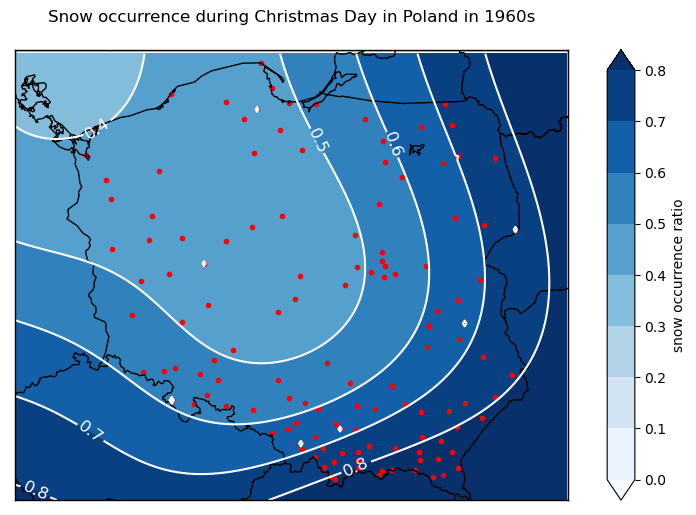

In [27]:
# Defining size of the plot and the title
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Snow occurrence during Christmas Day in Poland in 1960s', pad=20)

# Creating the basemap object and projection with the area of Poland
m = Basemap(projection='merc',
            resolution='i',llcrnrlat=49,urcrnrlat=55,llcrnrlon=13,urcrnrlon=25, ax=ax)
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 

# Converting x and y coordinates into basemap coordinates system
x,y = m(xintrp, yintrp)

# Drawing a filled contour plot with marked areas of snow occurrence ratio 
cs = ax.contourf(x, y, z1, levels=np.linspace(0,0.8,9),  extend='both', cmap='Blues')

# Creating a colorbar
cbar = m.colorbar(cs,location='right',pad="7%")
cbar.ax.set_ylabel('snow occurrence ratio')

# Drawing contour lines to better mark the boundaries between areas
cs2 = plt.contour(x, y, z1, levels=np.linspace(0,0.8,9), colors='white')
ax.clabel(cs2, cs2.levels, inline=True, fontsize=12)

# (optional) marking the location of weather stations
lonsm, latsm = m(lons, lats)
m.scatter(lonsm, latsm, marker = '.', color='r')

## Map of snow occurence during entire period of collecting meteo data

Now let's answer the main question, what is the chance of snow on Christmas based on historical data? First, we need to generate a dataframe with data for the entire period. For this purpose, we will slightly modify the function *snow_data_range*

In [28]:
def snow_data_range2(dataframe, period):
    
    # Selecting records from a dataframe for a given time period (argument as a tuple)
    df = dataframe.loc[(dataframe['year'] >= period[0]) & (dataframe['year'] <= period[1])]
   
    # Creating the Series with station names
    station_name = df.groupby('station_id').first()[['station_name','lat','lon']]

    # Creating the Series with number of total years of measurements
    total_years = df.groupby('station_id')['station_name'].count()

    # Creating the Series with all snowy years counted (with snow cover of at least 2 cm)
    snowy_years = df.groupby('station_id').apply(lambda x: x[x['snow'] > 1 ]['year'].count())

    # Creating the Series with calculated snow occurrence ratio (simply dividing number of snowy years by number of total years for each station)
    snow_occurr = (snowy_years / total_years)
 
    # Creating the Series with an average snow cover
    snow_mean =  df.groupby('station_id')['snow'].agg('mean')
    
    # Merging all Series into one final dataframe and adding latitude/longitude columns
    df = pd.concat({"station_name":station_name['station_name'],"total_years":total_years,"snowy_years":snowy_years, \
                  "snow_occurr":snow_occurr,"snow_mean":snow_mean, "lat":station_name['lat'], "lon":station_name['lon']}, axis=1)
    
    # Returning the final dataframe for all stations regardless of the number of years of measurement
    return df

In [30]:
# Displaying the data for entire time frame

snow_all = snow_data_range2(df,(1951,2021))
snow_all.sample(10)

,station_name,total_years,snowy_years,snow_occurr,snow_mean,lat,lon
station_id,,,,,,,
250160610,BOLESŁAWÓW,26,19,0.730769,10.153846,50.250000,16.883333
252209997,NIEPOKALANÓW,30,10,0.333333,2.566667,52.200000,20.416667
252159995,BABIMOST,4,1,0.250000,2.250000,52.133333,15.783333
249190890,RADZIECHOWY,14,2,0.142857,0.571429,49.648611,19.155556
252180080,KOŁUDA WIELKA,71,20,0.281690,2.647887,52.733333,18.150000
249200420,NIEDZICA,24,15,0.625000,6.666667,49.416667,20.316667
252210050,PUŁTUSK,71,22,0.309859,3.915493,52.067778,21.001667
253220070,BIEBRZA-PIEŃCZYKÓWEK,65,26,0.400000,4.553846,53.650000,22.600000
249210070,BIECZ-GRUDNA,59,30,0.508475,4.966102,49.733333,21.250000


From the analysis in the previous notebook, we know that there are results from only 11 stations in the entire period of 71 years of measurements. There are a bit few stations to perform effective data interpolation. Therefore, it is necessary to slightly reduce the range of total years of measurements so that more stations are included in it.

In [31]:
snow_all.loc[snow_all['total_years'] == 71]

,station_name,total_years,snowy_years,snow_occurr,snow_mean,lat,lon
station_id,,,,,,,
249220040,DYNÓW,71,31,0.436620,5.000000,49.833333,22.233333
250190390,KRAKÓW-OBSERWATORIUM,71,26,0.366197,3.126761,50.066667,19.966667
251190050,PUCZNIEW,71,18,0.253521,2.281690,51.783333,19.083333
251200030,SKIERNIEWICE,71,14,0.197183,1.605634,51.966667,20.166667
251210120,PUŁAWY,71,23,0.323944,2.507042,51.416667,21.966667
252180080,KOŁUDA WIELKA,71,20,0.281690,2.647887,52.733333,18.150000
252200120,LEGIONOWO,71,22,0.309859,2.408451,52.400000,20.966667
252200150,WARSZAWA-BIELANY,71,23,0.323944,2.605634,52.283333,20.966667
252210050,PUŁTUSK,71,22,0.309859,3.915493,52.067778,21.001667


In [33]:
# Displaying stations in descending order by number of total years of measurements

snow_all.sort_values(ascending=False, by='total_years').head(60)

,station_name,total_years,snowy_years,snow_occurr,snow_mean,lat,lon
station_id,,,,,,,
252220030,SZEPIETOWO,71,26,0.366197,4.056338,52.850000,22.550000
251210120,PUŁAWY,71,23,0.323944,2.507042,51.416667,21.966667
251190050,PUCZNIEW,71,18,0.253521,2.281690,51.783333,19.083333
252180080,KOŁUDA WIELKA,71,20,0.281690,2.647887,52.733333,18.150000
252200120,LEGIONOWO,71,22,0.309859,2.408451,52.400000,20.966667
252200150,WARSZAWA-BIELANY,71,23,0.323944,2.605634,52.283333,20.966667
252210050,PUŁTUSK,71,22,0.309859,3.915493,52.067778,21.001667
251200030,SKIERNIEWICE,71,14,0.197183,1.605634,51.966667,20.166667
250190390,KRAKÓW-OBSERWATORIUM,71,26,0.366197,3.126761,50.066667,19.966667


For further analysis, we take all stations where measurements have been carried out for *more than 58 years*. Thanks to this, we will get almost 60 different points on the map, which should give a more reliable data interpolation.

In [34]:
snow_all = snow_all.loc[snow_all['total_years'] >= 58]
snow_all

,station_name,total_years,snowy_years,snow_occurr,snow_mean,lat,lon
station_id,,,,,,,
249180010,PSZCZYNA,66,22,0.333333,3.515152,50.000000,18.916667
249190190,MAKÓW PODHALAŃSKI,59,30,0.508475,5.745763,49.733333,19.683333
249190350,ZAWOJA,58,40,0.689655,15.689655,49.616667,19.516667
249190560,JABŁONKA,61,42,0.688525,9.393443,49.466667,19.700000
249200180,LIMANOWA,70,42,0.600000,5.342857,49.683333,20.433333
249200260,ŁĄCKO,65,26,0.400000,3.938462,49.559444,20.439444
249200370,KROŚCIENKO,65,39,0.600000,7.276923,49.450000,20.433333
249200470,KRYNICA,60,46,0.766667,14.900000,49.416667,20.966667
249200490,MUSZYNA,60,43,0.716667,10.250000,49.350000,20.883333


Let's take a look at where exactly the selected stations are located on the map

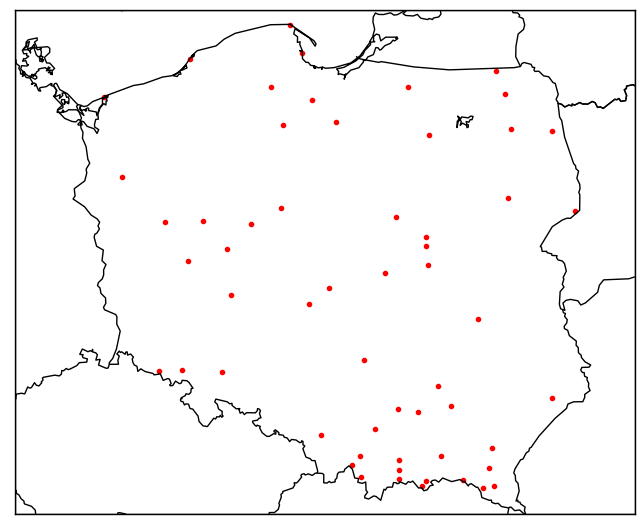

In [35]:
lons_stations = np.array(snow_all['lon'])
lats_stations = np.array(snow_all['lat'])

fig, ax = plt.subplots(figsize=(8,8))

m = Basemap(projection='merc',
            resolution='i',llcrnrlat=49,urcrnrlat=55,llcrnrlon=13,urcrnrlon=25)

m.drawcoastlines()
m.drawmapboundary()
m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 

lonsm, latsm = m(lons_stations, lats_stations)

m.scatter(lonsm, latsm, marker = '.', color='r')

plt.show()

Now that we have all the necessary data, let's create the final map with the marked occurrence of snow in the period of 58 years.

<a list of 4 text.Text objects>

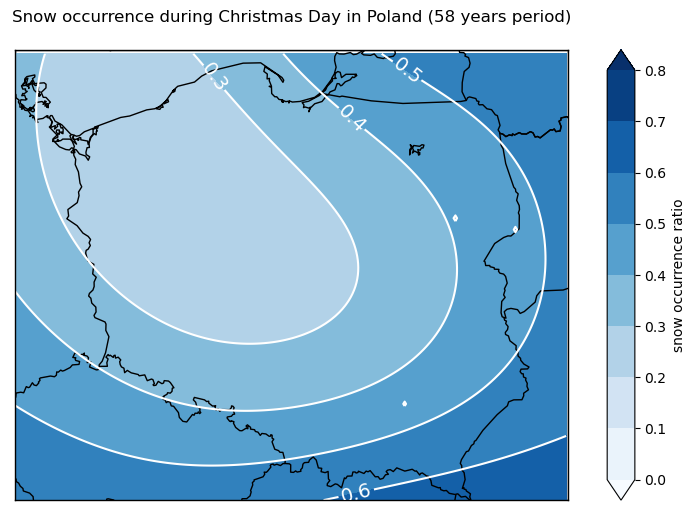

In [38]:
# Converting longitude, latitude, and snow occurrence ratio into numpy arrays 

lons = np.array(snow_all['lon'])
lats = np.array(snow_all['lat'])
data = np.array(snow_all['snow_occurr'])

# Creating a grid space for data interpolation

grid_space = 0.05
grid_lon = np.arange(np.array([13]), np.array([25]), grid_space) 
grid_lat = np.arange(np.array([49]), np.array([55]), grid_space)

# Executing the ordinary kriging algorithm

OK = OrdinaryKriging(lons, lats, data, variogram_model='gaussian', verbose=False, enable_plotting=False)
z1, ss1 = OK.execute('grid', grid_lon, grid_lat)

xintrp, yintrp = np.meshgrid(grid_lon, grid_lat)

# Defining size of the plot and the title
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title('Snow occurrence during Christmas Day in Poland (58 years period)', pad=20)

# Creating the basemap object and projection with the area of Poland
m = Basemap(projection='merc',
            resolution='i',llcrnrlat=49,urcrnrlat=55,llcrnrlon=13,urcrnrlon=25, ax=ax)
m.drawcoastlines()
m.drawmapboundary()
m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 

# Converting x and y coordinates into basemap coordinates system
x,y = m(xintrp, yintrp)

# Drawing a filled contour plot with marked areas of snow occurrence ratio 
cs = ax.contourf(x, y, z1, levels=np.linspace(0,0.8,9),  extend='both', cmap='Blues')

# Creating a colorbar
cbar = m.colorbar(cs,location='right',pad="7%")
cbar.ax.set_ylabel('snow occurrence ratio')

# Drawing contour lines to better mark the boundaries between areas
cs2 = plt.contour(x, y, z1, levels=np.linspace(0,0.8,9), colors='white')
ax.clabel(cs2, cs2.levels, inline=True, fontsize=14)



## Snow occurrence ratio comparison for each decade

Above is a graph showing the occurrence of snow on Christmas Day over a long period of 58 years. Let's check how the situation with snow looked separately for each decade from 1950s to 2010s.

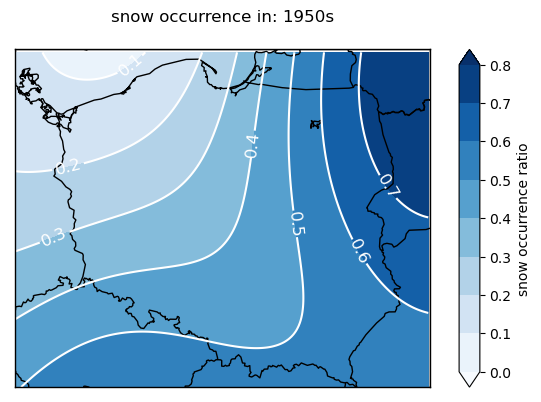

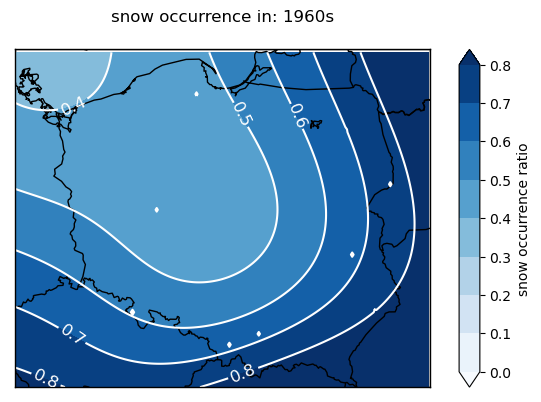

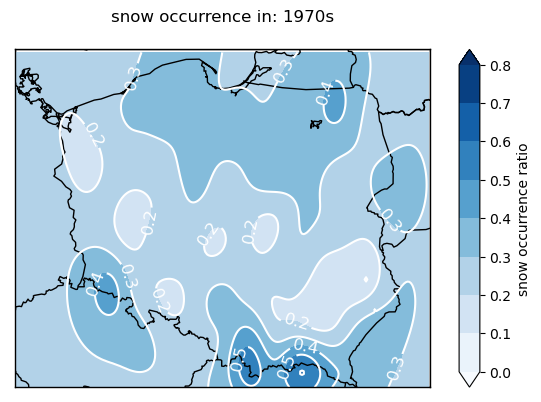

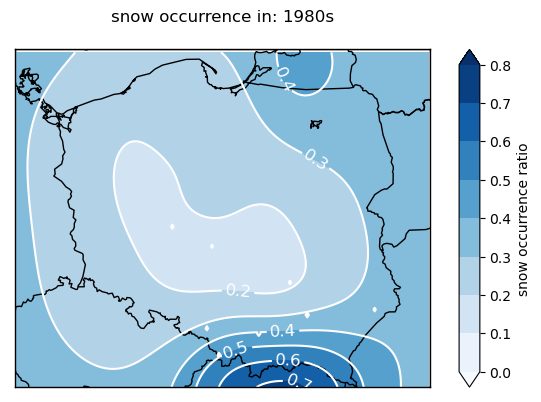

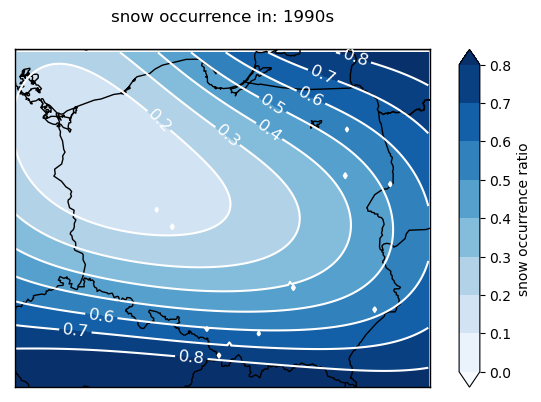

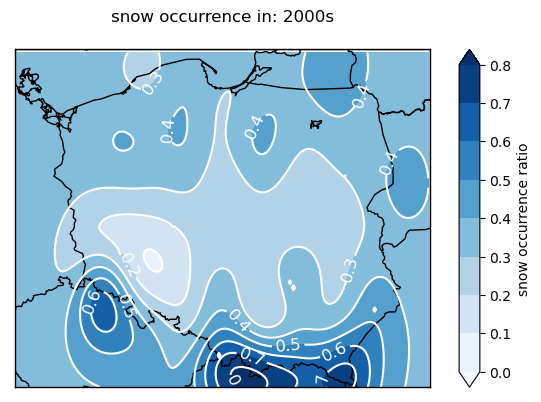

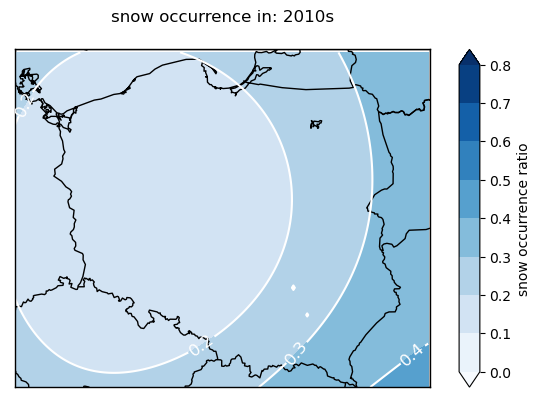

In [60]:
# Looping over every decade in a whole time period in order to create a plot for each decade with snow occurrence data

for i, period in enumerate(((1950,1959), (1960,1969), (1970,1979), (1980,1989), (1990,1999), (2000,2009), (2010,2019))):
   
    snow = snow_data_range(df, period)

    """
    During earlier analyses, it turned out that for the decade 2010-19 there is a problem with interpolation, 
    probably caused by too high a share of mountain stations. Therefore, for interpolation in this case, 
    we take only 46 measurements of stations located north of the mountains.
    """
    if period == (2010,2019):
        snow = snow.tail(46)

    lons=np.array(snow['lon'])
    lats=np.array(snow['lat'])
    data=np.array(snow['snow_occurr'])

    grid_space = 0.05
    grid_lon = np.arange(np.array([13]), np.array([25]), grid_space) 
    grid_lat = np.arange(np.array([49]), np.array([55]), grid_space)

    OK = OrdinaryKriging(lons, lats, data, variogram_model='gaussian', verbose=False, enable_plotting=False, nlags=20)
    z1, ss1 = OK.execute('grid', grid_lon, grid_lat)

    xintrp, yintrp = np.meshgrid(grid_lon, grid_lat)
    
    fig, ax = plt.subplots(figsize=(6,6))

    m = Basemap(projection='merc',
            resolution='i',llcrnrlat=49,urcrnrlat=55,llcrnrlon=13,urcrnrlon=25, ax=ax)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries(linewidth=1, linestyle='solid', color='k' ) 

    x,y = m(xintrp, yintrp)

    cs = ax.contourf(x, y, z1, levels=np.linspace(0,0.8,9),  extend='both', cmap='Blues')

    cbar = m.colorbar(cs,location='right',pad="7%")
    cbar.ax.set_ylabel('snow occurrence ratio')

    cs2 = plt.contour(x, y, z1, levels=np.linspace(0,0.8,9), colors='white')
    ax.clabel(cs2, cs2.levels, inline=True, fontsize=12)

    ax.set_title("snow occurrence in: " + str(period[0]) +"s", pad=20)

plt.show()

## Results and conclusions

- The average occurrence of snow on Christmas Day (based on 58 years of data) in most areas of Poland ranges from 0.2-0.4 (which means 2-4 snowy Christmas per 10 years)
- It is clear that the western part of the country has less chance of snow on Christmas. In some places, only 1 in 10 Christmas Days fall with snow.
- The greatest chance of snow (often 0.8-1) is in the south in the mountains, which is pretty obvious. We can also expect snow more often on Christmas in the north-east and east of Poland (with an average chance of 0.4-0.5).
- Over the course of 70 years of measurements, more and less snowy periods can be observed. The snowiest decades were in the 1950s and 1960s, and the least snow on Christmas was in the 1970s, 1980s and 2010s.
- Every few years (5-10) exceptionally snowy Christmas can be observed with an average snow cover thickness of more than 10 cm. This has happened 9 times in 70 years of measurements. Typically, the average snow cover is only several cm.
- Based on historical data from the last 70 years, it can be concluded that the so-called a white Christmas in Poland is less than likely. In addition, a truly white Christmas, when there was an average of over 10 cm of snow, occurred only 9 times. Therefore, we should not expect snow on December 25th. Also, the occurrence of snow does not depend on time, which means that once there were completely snow-free Christmas, e.g. in the late 1950s or in the 1970s
